In [61]:
import json
import random
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

# Load word2vec model
model = api.load("word2vec-google-news-300")

# Load sample data
with open('/home/grads/g/ganatma/Research/Ganatma/TAMUDatathon24/Connections AI/sample_data.json', 'r') as f:
    all_groups = json.load(f)


In [62]:
sample = 2

In [63]:
all_groups[sample]

[{'words': ['HASH', 'SALAD', 'SCRAMBLE', 'STEW'],
  'category': 'FOOD-RELATED JUMBLES'},
 {'words': ['CHARACTER', 'IMAGE', 'NAME', 'REPUTATION'],
  'category': 'PUBLIC STANDING'},
 {'words': ['ARTIST', 'MEDIUM', 'TITLE', 'YEAR'],
  'category': 'INFO ON A MUSEUM PLACARD'},
 {'words': ['DIAL', 'EGADS', 'MONTE', 'YOGA'],
  'category': 'ANAGRAMS OF FAMOUS PAINTERS'}]

In [64]:
def group_words_kmeans_fixed_size(words, similarity_matrix, words_per_group=4):
    n = len(words)
    assert n % words_per_group == 0, "Total words must be divisible by words_per_group"
    n_clusters = n // words_per_group
    
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    
    best_groups = None
    best_score = float('-inf')
    best_labels = None
    
    # Try multiple initializations to find the best grouping
    for _ in range(20):
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, random_state=None)
        labels = kmeans.fit_predict(distance_matrix)
        
        # Check if all clusters have exactly 4 words
        cluster_sizes = [sum(labels == i) for i in range(n_clusters)]
        if not all(size == words_per_group for size in cluster_sizes):
            continue
            
        # Calculate average similarity within groups
        total_score = 0
        for i in range(n_clusters):
            cluster_indices = [j for j, label in enumerate(labels) if label == i]
            similarities = []
            for idx1, idx2 in combinations(cluster_indices, 2):
                similarities.append(similarity_matrix[idx1][idx2])
            total_score += np.mean(similarities) if similarities else 0
            
        if total_score > best_score:
            best_score = total_score
            best_labels = labels
    
    if best_labels is None:
        # Fallback: Use greedy approach if K-means fails to find valid groups
        return group_words_greedy(words, similarity_matrix, words_per_group)
    
    # Organize words into groups
    groups = [[] for _ in range(n_clusters)]
    for word, cluster_idx in zip(words, best_labels):
        groups[cluster_idx].append(word)
    
    # Calculate final group scores
    group_scores = []
    for group in groups:
        group_indices = [words.index(word) for word in group]
        similarities = []
        for i, j in combinations(group_indices, 2):
            similarities.append(similarity_matrix[i][j])
        avg_similarity = np.mean(similarities) if similarities else 0
        group_scores.append(avg_similarity)
    
    # Sort groups by their internal similarity scores
    sorted_groups = [x for _, x in sorted(zip(group_scores, groups), reverse=True)]
    sorted_scores = sorted(group_scores, reverse=True)
    
    return sorted_groups, sorted_scores

def group_words_greedy(words, similarity_matrix, words_per_group=4):
    n = len(words)
    n_groups = n // words_per_group
    groups = []
    remaining_words = set(range(n))
    
    while len(groups) < n_groups:
        best_group = None
        best_score = float('-inf')
        
        # Try all possible combinations of remaining words
        for combo in combinations(remaining_words, words_per_group):
            score = 0
            for i, j in combinations(combo, 2):
                score += similarity_matrix[i][j]
            if score > best_score:
                best_score = score
                best_group = combo
        
        if best_group:
            groups.append([words[i] for i in best_group])
            remaining_words -= set(best_group)
    
    # Calculate group scores
    group_scores = []
    for group in groups:
        indices = [words.index(word) for word in group]
        similarities = []
        for i, j in combinations(indices, 2):
            similarities.append(similarity_matrix[i][j])
        group_scores.append(np.mean(similarities))
    
    return groups, group_scores


Group 1 (Average Similarity: 0.396):
Words: BENT, GNARLY, TWISTED, WARPED

Group 2 (Average Similarity: 0.209):
Words: LICK, SHRED, TRACE, ROOT

Group 3 (Average Similarity: 0.138):
Words: POWER, BATH, REST, THRONE

Group 4 (Average Similarity: 0.080):
Words: OUNCE, EXPONENT, RADICAL, POWDER


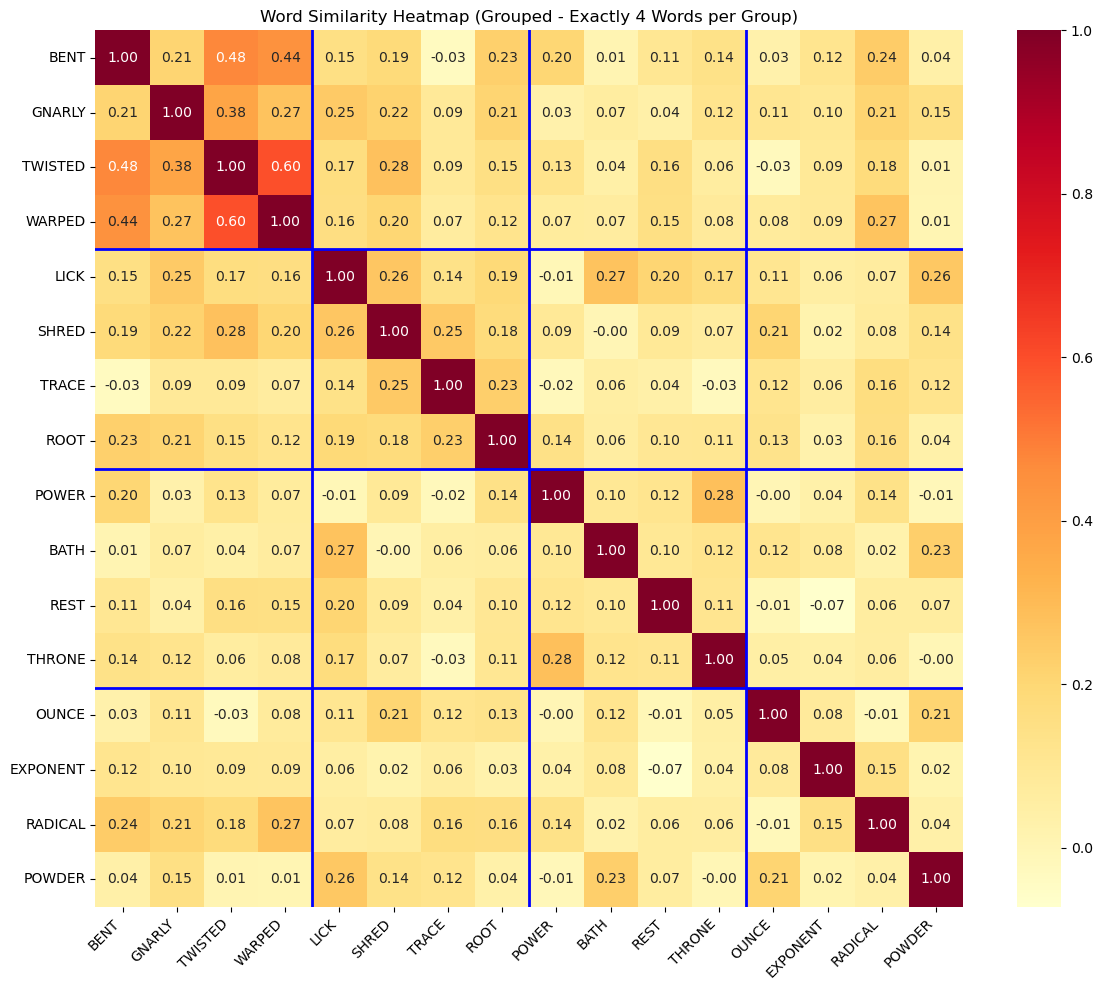

[{'words': ['BENT', 'GNARLY', 'TWISTED', 'WARPED'], 'category': 'CONTORTED'}, {'words': ['LICK', 'OUNCE', 'SHRED', 'TRACE'], 'category': 'SMALLEST AMOUNT'}, {'words': ['EXPONENT', 'POWER', 'RADICAL', 'ROOT'], 'category': 'ALGEBRA TERMS'}, {'words': ['BATH', 'POWDER', 'REST', 'THRONE'], 'category': 'WORDS BEFORE “ROOM” TO MEAN LAVATORY'}]


In [65]:
for sample in range(1):#range(len(all_groups)):
    words = [entry['words'] for entry in all_groups[sample]]
    linearized_words = [word for sublist in words for word in sublist]

    word_vectors = np.array([model[word.lower()] for word in linearized_words if word.lower() in model])

    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(word_vectors)

    groups, scores = group_words_kmeans_fixed_size(linearized_words, similarity_matrix)

    # Print the groups with their similarity scores
    for i, (group, score) in enumerate(zip(groups, scores), 1):
        print(f"\nGroup {i} (Average Similarity: {score:.3f}):")
        print(f"Words: {', '.join(group)}")

    # Visualize with heatmap
    plt.figure(figsize=(12, 10))

    # Reorder the similarity matrix based on groups
    all_grouped_words = []
    for group in groups:
        all_grouped_words.extend(group)

    reordered_idx = [linearized_words.index(word) for word in all_grouped_words]
    reordered_matrix = similarity_matrix[reordered_idx][:, reordered_idx]

    # Create heatmap with group boundaries
    sns.heatmap(reordered_matrix,
                annot=True,
                cmap='YlOrRd',
                xticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
                yticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
                fmt='.2f')

    # Add group boundaries
    current_idx = 0
    for _ in range(3):  # 3 lines for 4 groups
        current_idx += 4
        plt.axhline(y=current_idx, color='blue', linewidth=2)
        plt.axvline(x=current_idx, color='blue', linewidth=2)

    plt.title('Word Similarity Heatmap (Grouped - Exactly 4 Words per Group)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(all_groups[sample])

In [48]:
def analyze_group_context(words, model, topn=10):
    """
    Find common contexts/themes between a group of words using word2vec
    """
    # Get all pairwise similarities and their common similar words
    common_contexts = {}
    
    # Find words that are similar to all words in the group
    similar_to_all = None
    
    for word in words:
        if word.lower() in model:
            # Get similar words for this word
            similar_words = dict(model.most_similar(word.lower(), topn=topn*2))
            
            if similar_to_all is None:
                similar_to_all = set(similar_words.keys())
            else:
                similar_to_all &= set(similar_words.keys())
    
    # Get pairwise relationships
    for word1, word2 in combinations(words, 2):
        if word1.lower() in model and word2.lower() in model:
            # Find words similar to both word1 and word2
            similar_to_1 = dict(model.most_similar(word1.lower(), topn=topn))
            similar_to_2 = dict(model.most_similar(word2.lower(), topn=topn))
            
            # Find common similar words
            common_words = set(similar_to_1.keys()) & set(similar_to_2.keys())
            
            if common_words:
                common_contexts[(word1, word2)] = list(common_words)

    return {
        'pairwise_contexts': common_contexts,
        'group_contexts': list(similar_to_all) if similar_to_all else []
    }

# Analyze each group
for i, group in enumerate(groups, 1):
    print(f"\nAnalyzing Group {i}: {', '.join(group)}")
    print("-" * 50)
    
    context_analysis = analyze_group_context(group, model)
    
    # Print common contexts for the whole group
    print("\nCommon themes across all words:")
    if context_analysis['group_contexts']:
        for context in context_analysis['group_contexts'][:5]:
            print(f"- {context}")
    else:
        print("No common themes found across all words")
    
    # Print pairwise relationships
    print("\nPairwise relationships:")
    for (word1, word2), common_words in context_analysis['pairwise_contexts'].items():
        print(f"\n{word1} & {word2} share contexts:")
        for common_word in common_words[:5]:
            print(f"- {common_word}")
    
    print("\n" + "="*50)



Analyzing Group 1: NOVEL, MESSAGE, TEXT, POEM
--------------------------------------------------

Common themes across all words:
No common themes found across all words

Pairwise relationships:


Analyzing Group 2: PLAY, DIFFERENT, CORRESPOND, WRITE
--------------------------------------------------

Common themes across all words:
No common themes found across all words

Pairwise relationships:


Analyzing Group 3: PAUSE, RECORD, STOP, YARDSTICK
--------------------------------------------------

Common themes across all words:
No common themes found across all words

Pairwise relationships:


Analyzing Group 4: NEW, ORIGINAL, BIPED, FURNITURE
--------------------------------------------------

Common themes across all words:
No common themes found across all words

Pairwise relationships:



In [56]:
def get_context_similarity(words, model, topn=10):
    """
    Calculate context similarity score between words based on shared similar words
    """
    try:
        # Get similar words for each word
        similar_words = {}
        for word in words:
            if word.lower() in model:
                similar_words[word] = set(dict(model.most_similar(word.lower(), topn=topn)).keys())
            else:
                return 0.0  # Return 0 if any word is not in model
        
        # Calculate pairwise context overlap
        context_scores = []
        for word1, word2 in combinations(words, 2):
            if word1 in similar_words and word2 in similar_words:
                overlap = len(similar_words[word1] & similar_words[word2])
                context_scores.append(overlap / topn)  # Normalize by topn
        
        # Return average context similarity
        return np.mean(context_scores) if context_scores else 0.0
        
    except Exception as e:
        print(f"Warning: Error calculating context similarity: {e}")
        return 0.0
def group_words_with_context(words, similarity_matrix, model, words_per_group=4, context_weight=0.3, max_attempts=50):
    """Group words considering both vector similarity and context similarity"""
    n = len(words)
    n_clusters = n // words_per_group
    
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    
    best_groups = None
    best_score = float('-inf')
    best_labels = None
    
    # Try multiple initializations with more attempts
    for _ in range(max_attempts):
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, random_state=None)
        labels = kmeans.fit_predict(distance_matrix)
        
        # Check if all clusters have exactly 4 words
        cluster_sizes = [sum(labels == i) for i in range(n_clusters)]
        if not all(size == words_per_group for size in cluster_sizes):
            continue
        
        # Calculate combined score (similarity + context)
        total_score = 0
        valid_clustering = True
        
        for i in range(n_clusters):
            cluster_indices = [j for j, label in enumerate(labels) if label == i]
            cluster_words = [words[j] for j in cluster_indices]
            
            try:
                # Vector similarity score
                similarities = []
                for idx1, idx2 in combinations(cluster_indices, 2):
                    similarities.append(similarity_matrix[idx1][idx2])
                sim_score = np.mean(similarities) if similarities else 0
                
                # Context similarity score
                context_score = get_context_similarity(cluster_words, model)
                
                # Combined score
                group_score = (1 - context_weight) * sim_score + context_weight * context_score
                total_score += group_score
            except:
                valid_clustering = False
                break
        
        if valid_clustering and total_score > best_score:
            best_score = total_score
            best_labels = labels
    
    # If no valid clustering found, use fallback method
    if best_labels is None:
        print("Warning: Could not find optimal clustering, using fallback method...")
        return fallback_grouping(words, similarity_matrix, words_per_group)
    
    # Organize words into groups
    groups = [[] for _ in range(n_clusters)]
    for word, cluster_idx in zip(words, best_labels):
        groups[cluster_idx].append(word)
    
    # Calculate final scores
    group_scores = []
    context_scores = []
    
    for group in groups:
        # Calculate similarity score
        group_indices = [words.index(word) for word in group]
        similarities = []
        for i, j in combinations(group_indices, 2):
            similarities.append(similarity_matrix[i][j])
        sim_score = np.mean(similarities) if similarities else 0
        
        # Calculate context score
        try:
            context_score = get_context_similarity(group, model)
        except:
            context_score = 0
            
        # Combined score
        final_score = (1 - context_weight) * sim_score + context_weight * context_score
        group_scores.append(final_score)
        context_scores.append(context_score)
    
    # Sort groups by their scores
    sorted_indices = np.argsort(group_scores)[::-1]
    sorted_groups = [groups[i] for i in sorted_indices]
    sorted_scores = [group_scores[i] for i in sorted_indices]
    sorted_context_scores = [context_scores[i] for i in sorted_indices]
    
    return sorted_groups, sorted_scores, sorted_context_scores

def fallback_grouping(words, similarity_matrix, words_per_group=4):
    """Simple greedy grouping as fallback"""
    n = len(words)
    n_groups = n // words_per_group
    remaining_words = list(range(n))
    groups = []
    scores = []
    context_scores = []
    
    while len(groups) < n_groups and remaining_words:
        current_group = []
        current_indices = []
        
        # Start with the first available word
        start_idx = remaining_words[0]
        current_indices.append(start_idx)
        current_group.append(words[start_idx])
        remaining_words.remove(start_idx)
        
        # Find most similar words to complete the group
        while len(current_group) < words_per_group and remaining_words:
            best_score = float('-inf')
            best_idx = None
            
            for idx in remaining_words:
                score = np.mean([similarity_matrix[idx][i] for i in current_indices])
                if score > best_score:
                    best_score = score
                    best_idx = idx
            
            if best_idx is not None:
                current_indices.append(best_idx)
                current_group.append(words[best_idx])
                remaining_words.remove(best_idx)
        
        if len(current_group) == words_per_group:
            groups.append(current_group)
            scores.append(best_score)
            context_scores.append(0)  # Simple fallback doesn't compute context scores
    
    return groups, scores, context_scores

# Rest of the code remains the same...

In [57]:
# Apply the improved grouping
groups, scores, context_scores = group_words_with_context(linearized_words, similarity_matrix, model)

# Print results with both similarity and context information
print("\nPredicted Groups:")
for i, (group, score, context_score) in enumerate(zip(groups, scores, context_scores), 1):
    print(f"\nGroup {i}:")
    print(f"Words: {', '.join(group)}")
    print(f"Combined Score: {score:.3f}")
    print(f"Context Score: {context_score:.3f}")
    
    # Analyze and print common contexts
    context_analysis = analyze_group_context(group, model)
    print("\nCommon themes:")
    if context_analysis['group_contexts']:
        for context in context_analysis['group_contexts'][:3]:
            print(f"- {context}")
    else:
        print("No common themes found")

# Visualize with heatmap (same as before)
plt.figure(figsize=(12, 10))
all_grouped_words = []
for group in groups:
    all_grouped_words.extend(group)

reordered_idx = [words.index(word) for word in all_grouped_words]
reordered_matrix = similarity_matrix[reordered_idx][:, reordered_idx]

sns.heatmap(reordered_matrix,
            annot=True,
            cmap='YlOrRd',
            xticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            yticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            fmt='.2f')

current_idx = 0
for _ in range(3):
    current_idx += 4
    plt.axhline(y=current_idx, color='blue', linewidth=2)
    plt.axvline(x=current_idx, color='blue', linewidth=2)

plt.title('Word Similarity Heatmap (Grouped with Context)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Predicted Groups:

Group 1:
Words: BENT, TWISTED, WARPED, GNARLY
Combined Score: 0.288
Context Score: 0.000

Common themes:
No common themes found

Group 2:
Words: LICK, BATH, POWDER, OUNCE
Combined Score: 0.147
Context Score: 0.000

Common themes:
No common themes found

Group 3:
Words: SHRED, TRACE, ROOT, RADICAL
Combined Score: 0.133
Context Score: 0.000

Common themes:
No common themes found

Group 4:
Words: EXPONENT, THRONE, POWER, REST
Combined Score: 0.053
Context Score: 0.000

Common themes:
No common themes found


ValueError: 'BENT' is not in list

<Figure size 1200x1000 with 0 Axes>

In [58]:
def get_context_similarity(words, model, topn=10):
    """
    Calculate context similarity score between words based on shared similar words
    """
    try:
        # Debug print
        print(f"\nCalculating context similarity for: {words}")
        
        # Get similar words for each word
        similar_words = {}
        for word in words:
            word = word.lower()
            if word in model:
                # Get similar words and their scores
                similar = model.most_similar(word, topn=topn)
                similar_words[word] = set(word for word, score in similar)
                # Debug print
                print(f"\nSimilar words to {word}:")
                for w, score in similar[:3]:  # Show top 3 for brevity
                    print(f"- {w} ({score:.3f})")
            else:
                print(f"Warning: '{word}' not in model")
                return 0.0
        
        # Calculate pairwise context overlap
        context_scores = []
        for word1, word2 in combinations([w.lower() for w in words], 2):
            overlap = len(similar_words[word1] & similar_words[word2])
            similarity = overlap / topn
            context_scores.append(similarity)
            # Debug print
            print(f"\nOverlap between {word1} & {word2}: {overlap} words (similarity: {similarity:.3f})")
            if overlap > 0:
                print("Shared words:", list(similar_words[word1] & similar_words[word2])[:3])
        
        final_score = np.mean(context_scores) if context_scores else 0.0
        print(f"\nFinal context score: {final_score:.3f}")
        return final_score
        
    except Exception as e:
        print(f"Error in context similarity calculation: {e}")
        return 0.0

# Test the function with a few example words
test_words = ["king", "queen", "prince", "princess"]  # Should have high context similarity
print("\nTesting with royal words:")
royal_score = get_context_similarity(test_words, model)
print(f"Royal words context score: {royal_score:.3f}")

# Test with the actual groups
print("\nTesting with actual groups:")
for i, group in enumerate(groups, 1):
    print(f"\nGroup {i}:")
    score = get_context_similarity(group, model)
    print(f"Context score: {score:.3f}")


Testing with royal words:

Calculating context similarity for: ['king', 'queen', 'prince', 'princess']

Similar words to king:
- kings (0.714)
- queen (0.651)
- monarch (0.641)

Similar words to queen:
- queens (0.740)
- princess (0.707)
- king (0.651)

Similar words to prince:
- princes (0.705)
- princess (0.699)
- monarch (0.669)

Similar words to princess:
- princesses (0.739)
- queen (0.707)
- prince (0.699)

Overlap between king & queen: 1 words (similarity: 0.100)
Shared words: ['monarch']

Overlap between king & prince: 3 words (similarity: 0.300)
Shared words: ['princes', 'monarch', 'crown_prince']

Overlap between king & princess: 2 words (similarity: 0.200)
Shared words: ['queen', 'prince']

Overlap between queen & prince: 4 words (similarity: 0.400)
Shared words: ['princess', 'monarch', 'king']

Overlap between queen & princess: 1 words (similarity: 0.100)
Shared words: ['princesses']

Overlap between prince & princess: 0 words (similarity: 0.000)

Final context score: 0.18

In [71]:
def group_words_with_gpt2_context(words, similarity_matrix, gpt2_model, gpt2_tokenizer, 
                                 words_per_group=4, vector_weight=0.6):
    """Group words using both vector similarity and GPT-2 context analysis"""
    n = len(words)
    n_clusters = n // words_per_group
    
    try:
        # Convert similarity matrix to distance matrix
        distance_matrix = 1 - similarity_matrix
        
        best_groups = None
        best_score = float('-inf')
        best_labels = None
        best_analysis = None
        
        # Try multiple initializations
        for attempt in range(20):
            try:
                kmeans = KMeans(n_clusters=n_clusters, n_init=1, random_state=attempt)
                labels = kmeans.fit_predict(distance_matrix)
                
                # Check cluster sizes
                cluster_sizes = [sum(labels == i) for i in range(n_clusters)]
                if not all(size == words_per_group for size in cluster_sizes):
                    continue
                
                # Calculate combined score
                total_score = 0
                current_analysis = []
                valid_clustering = True
                
                for i in range(n_clusters):
                    cluster_indices = [j for j, label in enumerate(labels) if label == i]
                    cluster_words = [words[j] for j in cluster_indices]
                    
                    try:
                        # Vector similarity score
                        vec_similarities = []
                        for idx1, idx2 in combinations(cluster_indices, 2):
                            vec_similarities.append(similarity_matrix[idx1][idx2])
                        vec_score = np.mean(vec_similarities) if vec_similarities else 0
                        
                        # GPT-2 context score
                        gpt2_result = get_gpt2_context_similarity(cluster_words, gpt2_model, gpt2_tokenizer)
                        context_score = gpt2_result['score']
                        current_analysis.append(gpt2_result)
                        
                        # Combined score
                        group_score = vector_weight * vec_score + (1 - vector_weight) * context_score
                        total_score += group_score
                    except Exception as e:
                        print(f"Error processing cluster {i}: {e}")
                        valid_clustering = False
                        break
                
                if valid_clustering and total_score > best_score:
                    best_score = total_score
                    best_labels = labels
                    best_analysis = current_analysis
                    
            except Exception as e:
                print(f"Error in attempt {attempt}: {e}")
                continue
        
        # If no valid clustering found, use fallback method
        if best_labels is None:
            print("Warning: Using fallback grouping method...")
            return fallback_grouping(words, similarity_matrix, gpt2_model, gpt2_tokenizer)
        
        # Organize final groups
        groups = [[] for _ in range(n_clusters)]
        for word, cluster_idx in zip(words, best_labels):
            groups[cluster_idx].append(word)
        
        return groups, best_score, best_analysis
        
    except Exception as e:
        print(f"Error in main grouping function: {e}")
        return fallback_grouping(words, similarity_matrix, gpt2_model, gpt2_tokenizer)

def fallback_grouping(words, similarity_matrix, gpt2_model, gpt2_tokenizer, words_per_group=4):
    """Simple greedy grouping as fallback"""
    n = len(words)
    n_groups = n // words_per_group
    remaining_words = list(range(n))
    groups = []
    analyses = []
    
    while len(groups) < n_groups and remaining_words:
        current_group = []
        current_indices = []
        
        # Start with the first available word
        start_idx = remaining_words[0]
        current_indices.append(start_idx)
        current_group.append(words[start_idx])
        remaining_words.remove(start_idx)
        
        # Find most similar words to complete the group
        while len(current_group) < words_per_group and remaining_words:
            best_score = float('-inf')
            best_idx = None
            
            for idx in remaining_words:
                score = np.mean([similarity_matrix[idx][i] for i in current_indices])
                if score > best_score:
                    best_score = score
                    best_idx = idx
            
            if best_idx is not None:
                current_indices.append(best_idx)
                current_group.append(words[best_idx])
                remaining_words.remove(best_idx)
        
        if len(current_group) == words_per_group:
            groups.append(current_group)
            # Get GPT-2 analysis for the group
            try:
                analysis = get_gpt2_context_similarity(current_group, gpt2_model, gpt2_tokenizer)
            except:
                analysis = {'score': 0.0, 'analysis': 'Analysis failed', 'pairwise_scores': {}}
            analyses.append(analysis)
    
    return groups, 0.0, analyses  # Return score of 0.0 for fallback method


In [72]:
groups

In [73]:

# Print results with detailed analysis
print("\nGrouping Results:")
for i, (group, analysis) in enumerate(zip(groups, analyses), 1):
    print(f"\nGroup {i}:")
    print(f"Words: {', '.join(group)}")
    print("\nGPT-2 Analysis:")
    print(f"Context Score: {analysis['score']:.3f}")
    print("Generated Context:", analysis['analysis'])
    print("\nPairwise Similarities:")
    for pair, score in analysis['pairwise_scores'].items():
        print(f"{pair}: {score:.3f}")
    print("-" * 50)

# Visualize with heatmap (same as before)
plt.figure(figsize=(12, 10))
all_grouped_words = []
for group in groups:
    all_grouped_words.extend(group)

reordered_idx = [words.index(word) for word in all_grouped_words]
reordered_matrix = similarity_matrix[reordered_idx][:, reordered_idx]

sns.heatmap(reordered_matrix,
            annot=True,
            cmap='YlOrRd',
            xticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            yticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            fmt='.2f')

current_idx = 0
for _ in range(3):
    current_idx += 4
    plt.axhline(y=current_idx, color='blue', linewidth=2)
    plt.axvline(x=current_idx, color='blue', linewidth=2)

plt.title('Word Similarity Heatmap (Grouped with GPT-2 Context)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Grouping Results:


TypeError: 'NoneType' object is not iterable